# Machine Learning for People in a Hurry—Workbook

These are the hands-on exercises to accompany the workshop.

Enjoy! 🌈

In [1]:
# A bunch of imports...
import numpy as np
import pandas as pd
import joblib
from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.datasets import load_iris

from utils import display_tree

This notebook is broken into five major pieces that _skim_ the core machine learning workflow.

It is not intended to be comprehensive, though relevant material is linked at the bottom of each section.

The sections are...

1. Reading
2. Wrangling
3. Building
4. Tuning
5. Evaluating
6. Deploying

Another chit-chat. Let's get started!

## _but first..._

What's our problem?!

Machine learning is a **tool** to solve problems. It's one of many tools.

Today, it's used a bit like a hammer (and when you're a hammer 🔨, everything looks like a nail 💅). Consider alterative approaches like...

- an algorithm (...could you solve the problem exactly?)
- a heuristic (...is there a good way to 'guess' that doesn't involve ML?)
- humans?! (...perhaps machines aren't cut out for this sort of problem...)

With that out of the way, let's introduce our goal for today.

We'll be working with a [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) endgame data set to try and predict whether or not "X" (assumed to move first) will win.

Formally, **can we predict the outcome of a tic-tac-toe game based on the current state of the board?**

There's lots of neat ways you could apply this data set, such as...

- Building a tic-tac-toe (of varying levels of difficulty)
- A tic-tac-toe "analysis tool" (to tell you if your move as good, or bad)

though, it's a bit trivial with a game this simple. It's a toy example, but you could find more complex games to try it on (e.g., [chess](https://www.kaggle.com/datasets/datasnaek/chess), and [many, many, more](https://github.com/leomaurodesenv/game-datasets)).

## Reading

Let's read in the data!

In [2]:
DATA_PATH = "../data"

In [3]:
tictactoe_df = pd.read_csv(
    f"{DATA_PATH}/tictactoe.data", 
    names=["top-left-square",    "top-middle-square",    "top-right-square",
           "middle-left-square", "middle-middle-square", "middle-right-square",
           "bottom-left-square", "bottom-middle-square", "bottom-right-square",
          "class"],
    header=None
)

tictactoe_df.head(5)

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [4]:
tictactoe_df.tail(5)

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative
957,o,o,x,x,x,o,o,x,x,negative


In [5]:
profile = ProfileReport(tictactoe_df, title="Profiling Report")

In [6]:
profile.to_file("tictactoe.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Wrangling

In this next section, we'll explore data wrangling briefly, and perform it on our data set.

In [7]:
# First, let's split our data
train_df, test_df = train_test_split(tictactoe_df, test_size=0.20, random_state=123)

target = "class"
column_names = [column for column in tictactoe_df.columns if column != target]

X_train, y_train = (
    train_df.drop(columns=[target]),
    train_df[target],
)

X_test, y_test = (
    test_df.drop(columns=[target]),
    test_df[target],
)

In [8]:
X_train.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
335,o,x,o,o,b,b,x,x,x
196,x,o,b,x,o,x,x,b,o
648,x,x,o,b,x,x,o,o,o
776,o,x,o,x,o,x,o,x,b
13,x,x,x,o,x,o,o,x,o


In [9]:
y_train.head()

335    positive
196    positive
648    negative
776    negative
13     positive
Name: class, dtype: object

In [10]:
enc = OneHotEncoder(sparse_output=False)

enc.fit(X_train)
X_train_enc = enc.transform(X_train)

# Convert it back to a dataframe
X_train_enc = pd.DataFrame(
    data=X_train_enc,
    columns=enc.get_feature_names_out(column_names),
    index=X_train.index,
)

X_train_enc.head()

,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,middle-left-square_b,...,middle-right-square_x,bottom-left-square_b,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x
335,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
196,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
648,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
776,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
13,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


`scikit-learn` provides a wonderful interface for this (and more complex transformations) called a pipeline.

This will allow us to transform our test data _the same way_.

In [11]:
# First, we build a column transformer

# In this case... it's rather trivial!
categorical_feats = column_names

ct = make_column_transformer(    
    (OneHotEncoder(), categorical_feats),
)

In [12]:
ct

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['top-left-square', 'top-middle-square',
                                  'top-right-square', 'middle-left-square',
                                  'middle-middle-square', 'middle-right-square',
                                  'bottom-left-square', 'bottom-middle-square',
                                  'bottom-right-square'])])

In [13]:
X_train_transformed = ct.fit_transform(X_train)

X_train_transformed

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [14]:
column_names = (
    ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)

column_names[:5]

['top-left-square_b',
 'top-left-square_o',
 'top-left-square_x',
 'top-middle-square_b',
 'top-middle-square_o']

In [15]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=column_names)

X_train_transformed.head()

,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,middle-left-square_b,...,middle-right-square_x,bottom-left-square_b,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [16]:
pipe = make_pipeline(ct, DecisionTreeClassifier())

pipe.fit(X_train, y_train)

pipe.predict(X_train)[:5]

array(['positive', 'positive', 'negative', 'negative', 'positive'],
      dtype=object)

In [17]:
pipe.score(X_train, y_train)

1.0

In [18]:
pipe.score(X_test, y_test)

0.9583333333333334

## A brief aside: other kinds of transformations

It's not all one hot encoding. Let's see a few other examples, before moving along.

In [19]:
iris_df = load_iris()

iris_df = pd.DataFrame(data= np.c_[iris_df['data'], iris_df['target']], columns= iris_df['feature_names'] + ['target'])
iris_df.head()

# (Sorry, this section is still TODO!)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


## Building (a model)

Let's start to toy around with a different kinds of models!

In [20]:
# What's the "dumbest" model we could make?
# ...predict the most likely class!

dc = DummyClassifier(strategy="most_frequent")

dc.fit(X_train, y_train)
dc.predict(X_train)[:5]

array(['positive', 'positive', 'positive', 'positive', 'positive'],
      dtype='<U8')

In [21]:
dc.score(X_train, y_train)

0.6540469973890339

In [22]:
dc.score(X_test, y_test)

0.6510416666666666

In [23]:
# Decision trees!
dt = DecisionTreeClassifier()

try:
    dt.fit(X_train, y_train)
except ValueError as error:
    print(error)

could not convert string to float: 'o'


In [24]:
dt_pipe = make_pipeline(ct, DecisionTreeClassifier())

dt_pipe.fit(X_train, y_train)
dt_pipe.predict(X_train)[:5]

array(['positive', 'positive', 'negative', 'negative', 'positive'],
      dtype=object)

In [25]:
# Perfect score! I wonder why...
dt_pipe.score(X_train, y_train)

1.0

In [26]:
dt_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['top-left-square',
                                                   'top-middle-square',
                                                   'top-right-square',
                                                   'middle-left-square',
                                                   'middle-middle-square',
                                                   'middle-right-square',
                                                   'bottom-left-square',
                                                   'bottom-middle-square',
                                                   'bottom-right-square'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

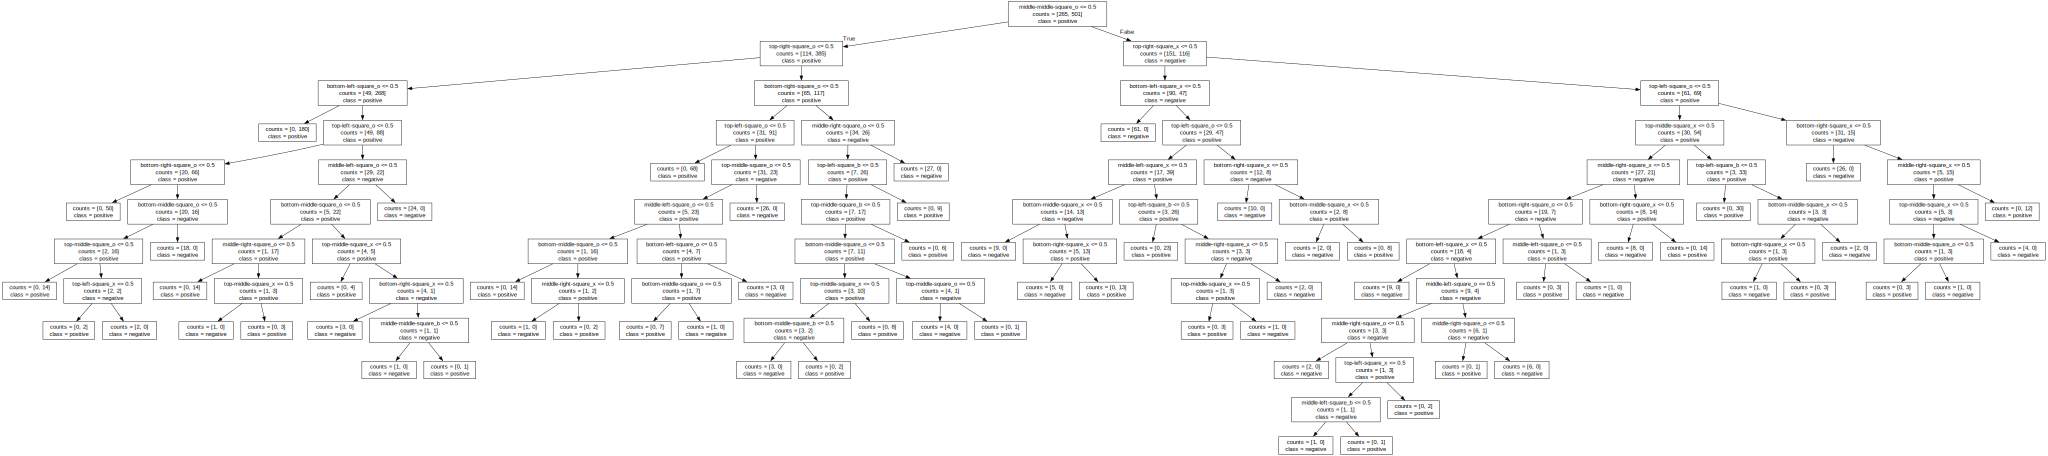

In [27]:
display_tree(dt_pipe[0].named_transformers_["onehotencoder"].get_feature_names_out().tolist(), dt_pipe[1], counts=True, index=1)

In [28]:
# Uhh... that trees sort-a complicated! How can we fix this?!

# Let's make a so-called "decision stump" to see the other extreme
ds = DecisionTreeClassifier(max_depth=1)

ds_pipe = make_pipeline(ct, ds)

ds_pipe.fit(X_train, y_train)
ds_pipe.predict(X_train)[:5]

array(['positive', 'negative', 'positive', 'negative', 'positive'],
      dtype=object)

In [29]:
ds_pipe.score(X_train, y_train)

0.6997389033942559

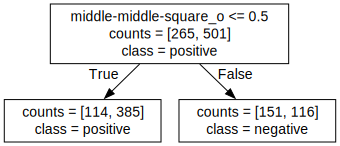

In [30]:
display_tree(ds_pipe[0].named_transformers_["onehotencoder"].get_feature_names_out().tolist(), ds_pipe[1], counts=True, index=2)

### The best move in tic-tac-toe!

It looks like that middle-middle square _is_ the best first move after all. An empty center gives our model quite a bit of hope we can win. (With only that one piece of information, we beat guessing by ~15%! Though, we also haven't beat our dummy classifier by anything at all...)

## Tuning

In [31]:
# Let's prevent overfitting...
results_dict = {
    "max_depth": [],
    
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}

param_grid = {"max_depth": np.arange(1, 50, 5)}

for max_depth in param_grid["max_depth"]:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    model = ds_pipe = make_pipeline(ct, dt)

    scores = cross_validate(model, X_train, y_train, return_train_score=True)
    results_dict["max_depth"].append(max_depth)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)

In [32]:
results_df

,max_depth,mean_train_score,mean_cv_score,std_cv_score,std_train_score
0,1,0.699739,0.699737,0.007202,0.001798
1,6,0.953983,0.900722,0.031691,0.009583
2,11,0.999674,0.932069,0.026070,0.000653
3,16,1.000000,0.934691,0.023803,0.000000
4,21,1.000000,0.924234,0.030325,0.000000
5,26,1.000000,0.929463,0.023957,0.000000
6,31,1.000000,0.928164,0.022710,0.000000
7,36,1.000000,0.928156,0.034136,0.000000
8,41,1.000000,0.935999,0.027279,0.000000
9,46,1.000000,0.928164,0.021945,0.000000


Let's choose 16 as our maximum depth.

## Evaluation

So, how good did we do?

In [33]:
# First, re-train a model on all of our data

dt = DecisionTreeClassifier(max_depth=16)
dt_pipe = make_pipeline(ct, dt)

dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['top-left-square',
                                                   'top-middle-square',
                                                   'top-right-square',
                                                   'middle-left-square',
                                                   'middle-middle-square',
                                                   'middle-right-square',
                                                   'bottom-left-square',
                                                   'bottom-middle-square',
                                                   'bottom-right-square'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=16))])

In [34]:
dt_pipe.score(X_test, y_test)

0.9635416666666666

Woo, hoo! We're 95% accurate on the test set.

## Deployment

A _very_ brief note on "exporting" our model.

In [35]:
# Save the model to a file
model_filename = 'tictactoe.joblib'
joblib.dump(dt_pipe, model_filename)

['tictactoe.joblib']

In [36]:
loaded_model = joblib.load(model_filename)

In [37]:
loaded_model.score(X_test, y_test)

0.9635416666666666